In [ ]:
import torchvision.transforms as transforms
import onnxruntime as ort
import torch
from PIL import Image
import numpy as np
import pandas as pd
import glob
import os
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

CLASS_NAMES = [
    "AKIEC",
    "BCC",
    "BEN_OTH",
    "BKL",
    "DF",
    "INF",
    "MAL_OTH",
    "BEL",
    "NV",
    "SCCKA",
    "VASC",
]

base_img_dir = "../../dataset"


class ONNXInference:
    def __init__(self, model_path):
        """Initialize ONNX model session."""
        self.session = ort.InferenceSession(model_path)
        self.input_names = [inp.name for inp in self.session.get_inputs()]

    def preprocess_image(self, image_path):
        """Load and preprocess image to [0,1] and BCHW format."""
        img = Image.open(base_img_dir + "/" + image_path).convert("RGB")
        img = img.resize((512, 512))
        img_array = np.array(img, dtype=np.float32) / 255.0  # scale to [0,1]
        img_array = np.transpose(img_array, (2, 0, 1))  # HWC -> CHW
        img_array = np.expand_dims(img_array, axis=0)  # add batch dimension
        return img_array

    def predict(self, image_path, age, gender, location):
        """Run inference on a single image with demographic data."""
        image_tensor = self.preprocess_image(image_path)
        gender_encoded = 1.0 if gender.lower() == "m" else 0.0
        demo_tensor = np.array(
            [[float(age), gender_encoded, float(location)]], dtype=np.float32
        )
        inputs = {self.input_names[0]: image_tensor, self.input_names[1]: demo_tensor}
        outputs = self.session.run(None, inputs)
        probs = outputs[0].flatten()
        pred = np.argmax(probs)
        return probs, pred, CLASS_NAMES[pred]


# Load dataset
df = pd.read_csv("../../dataset/data.csv")
le = LabelEncoder()
df["Location"] = le.fit_transform(df["Location"])
# Find all ONNX models
model_folder = "../../models/2025-11-27"
# model_paths = [
#     "../../models/2025-11-27/speechmaster/18_model118.onnx",
#     "../../models/2025-11-27/speechmaster/62_model94.onnx",
#     "../../models/2025-11-27/speechmaster/122_model123.onnx",
#     "../../models/combine/2025-11-27/18vs62_down.onnx",
#     "../../models/combine/2025-11-27/18vs122_down.onnx",
# ]
model_paths = glob.glob(os.path.join(model_folder, "**", "*.onnx"), recursive=True)
model_paths.append("../../models/2025-11-27/speechmaster/18_model118.onnx")
model_paths.append("../../models/2025-11-27/speechmaster/62_model94.onnx")
print("Found models:", model_paths)

# Store results
results = {}

for model_path in model_paths:
    onnx_model = ONNXInference(model_path=model_path)
    model_result = {cls: 0 for cls in CLASS_NAMES}

    # Inner loop wrapped with tqdm for progress
    for _, row in tqdm(
        df.iterrows(), total=len(df), desc=f"Processing {model_path.split('/')[-1]}"
    ):
        probs, pred, cls = onnx_model.predict(
            row["NewFileName"], row["Age"], row["Gender"], row["Location"]
        )
        if row["Class"] in cls:
            model_result[row["Class"]] += 1

    results[model_path] = model_result

print("Evaluation results:")
for model_path, res in results.items():
    print(model_path, res)

Found models: ['../../models/2025-11-27/speechmaster/18_model118.onnx', '../../models/2025-11-27/speechmaster/62_model94.onnx', '../../models/2025-11-27/speechmaster/122_model123.onnx', '../../models/combine/2025-11-27/18vs62_down.onnx', '../../models/combine/2025-11-27/18vs122_down.onnx']


Processing 18vs122_down.onnx: 100%|██████████| 350/350 [01:41<00:00,  3.46it/s]

Evaluation results:
../../models/2025-11-27/speechmaster/18_model118.onnx {'AKIEC': 5, 'BCC': 11, 'BEN_OTH': 0, 'BKL': 15, 'DF': 4, 'INF': 8, 'MAL_OTH': 0, 'BEL': 0, 'NV': 237, 'SCCKA': 5, 'VASC': 0}
../../models/2025-11-27/speechmaster/62_model94.onnx {'AKIEC': 1, 'BCC': 13, 'BEN_OTH': 0, 'BKL': 11, 'DF': 4, 'INF': 6, 'MAL_OTH': 0, 'BEL': 0, 'NV': 259, 'SCCKA': 7, 'VASC': 0}
../../models/2025-11-27/speechmaster/122_model123.onnx {'AKIEC': 2, 'BCC': 13, 'BEN_OTH': 0, 'BKL': 10, 'DF': 3, 'INF': 10, 'MAL_OTH': 0, 'BEL': 0, 'NV': 248, 'SCCKA': 5, 'VASC': 0}
../../models/combine/2025-11-27/18vs62_down.onnx {'AKIEC': 5, 'BCC': 12, 'BEN_OTH': 0, 'BKL': 16, 'DF': 4, 'INF': 9, 'MAL_OTH': 0, 'BEL': 0, 'NV': 248, 'SCCKA': 5, 'VASC': 0}
../../models/combine/2025-11-27/18vs122_down.onnx {'AKIEC': 5, 'BCC': 13, 'BEN_OTH': 0, 'BKL': 17, 'DF': 4, 'INF': 9, 'MAL_OTH': 0, 'BEL': 0, 'NV': 239, 'SCCKA': 4, 'VASC': 0}


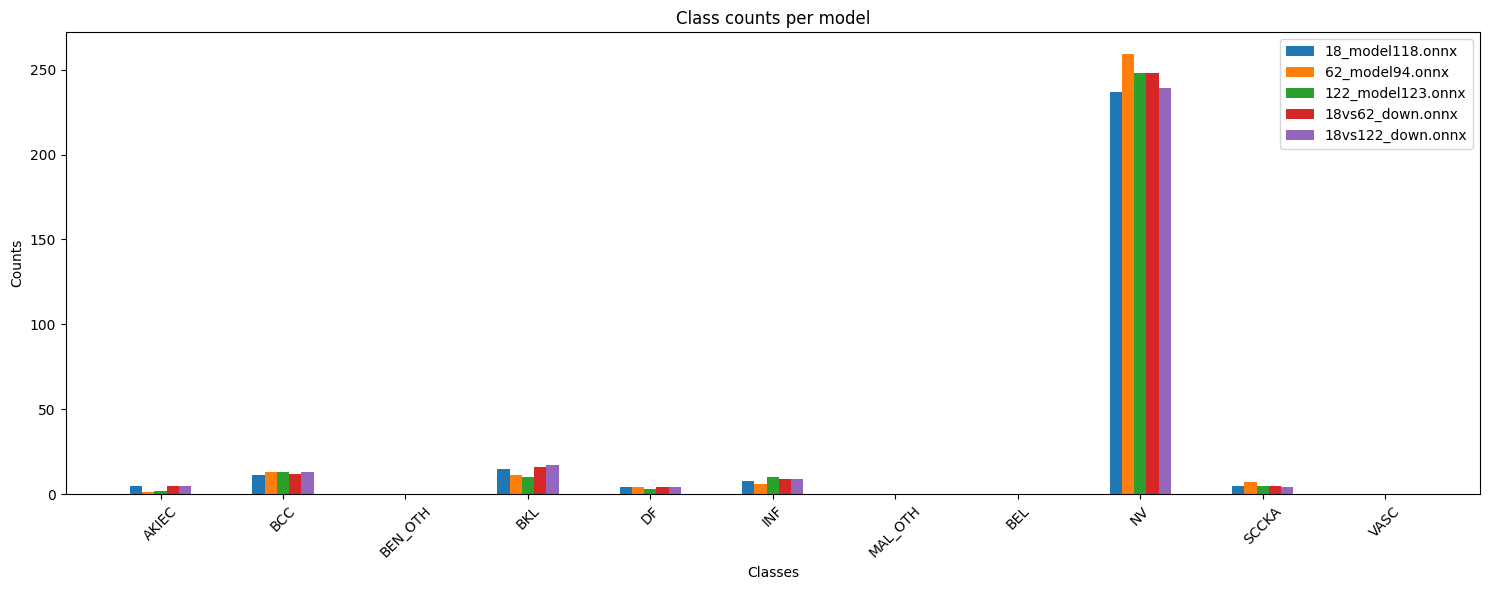

In [2]:
import matplotlib.pyplot as plt

classes = list(next(iter(results.values())).keys())
models = list(results.keys())

# Prepare data for plotting
data = []
for cls in classes:
    data.append([results[model][cls] for model in models])

# Grouped bar chart
x = np.arange(len(classes))  # label locations
width = 0.1  # width of each bar

fig, ax = plt.subplots(figsize=(15, 6))

for i, model in enumerate(models):
    counts = [results[model][cls] for cls in classes]
    ax.bar(x + i * width, counts, width, label=model.split("/")[-1])

ax.set_xlabel("Classes")
ax.set_ylabel("Counts")
ax.set_title("Class counts per model")
ax.set_xticks(x + width * (len(models) - 1) / 2)
ax.set_xticklabels(classes, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [3]:
print(results)

{'../../models/2025-11-27/speechmaster/18_model118.onnx': {'AKIEC': 5, 'BCC': 11, 'BEN_OTH': 0, 'BKL': 15, 'DF': 4, 'INF': 8, 'MAL_OTH': 0, 'BEL': 0, 'NV': 237, 'SCCKA': 5, 'VASC': 0}, '../../models/2025-11-27/speechmaster/62_model94.onnx': {'AKIEC': 1, 'BCC': 13, 'BEN_OTH': 0, 'BKL': 11, 'DF': 4, 'INF': 6, 'MAL_OTH': 0, 'BEL': 0, 'NV': 259, 'SCCKA': 7, 'VASC': 0}, '../../models/2025-11-27/speechmaster/122_model123.onnx': {'AKIEC': 2, 'BCC': 13, 'BEN_OTH': 0, 'BKL': 10, 'DF': 3, 'INF': 10, 'MAL_OTH': 0, 'BEL': 0, 'NV': 248, 'SCCKA': 5, 'VASC': 0}, '../../models/combine/2025-11-27/18vs62_down.onnx': {'AKIEC': 5, 'BCC': 12, 'BEN_OTH': 0, 'BKL': 16, 'DF': 4, 'INF': 9, 'MAL_OTH': 0, 'BEL': 0, 'NV': 248, 'SCCKA': 5, 'VASC': 0}, '../../models/combine/2025-11-27/18vs122_down.onnx': {'AKIEC': 5, 'BCC': 13, 'BEN_OTH': 0, 'BKL': 17, 'DF': 4, 'INF': 9, 'MAL_OTH': 0, 'BEL': 0, 'NV': 239, 'SCCKA': 4, 'VASC': 0}}


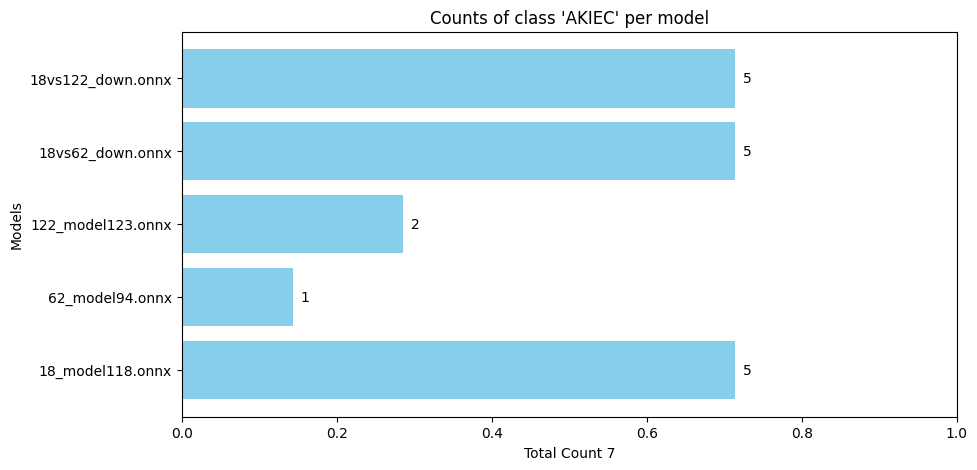

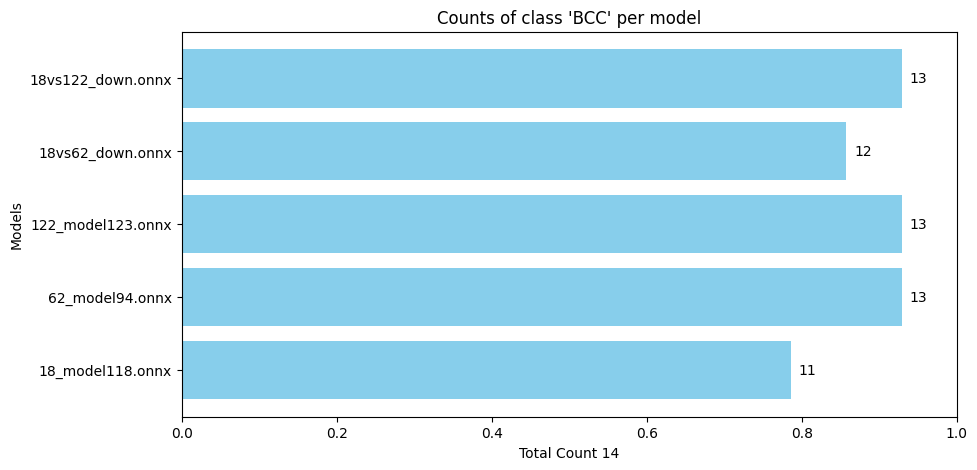

This class is not there


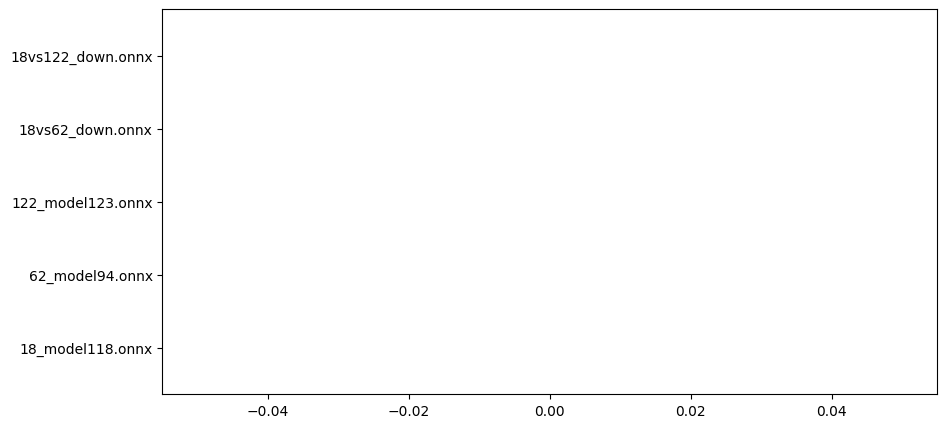

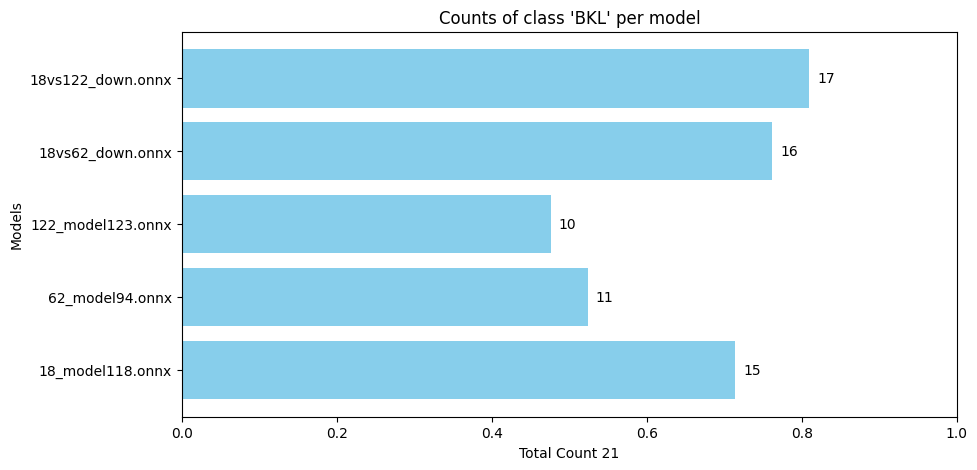

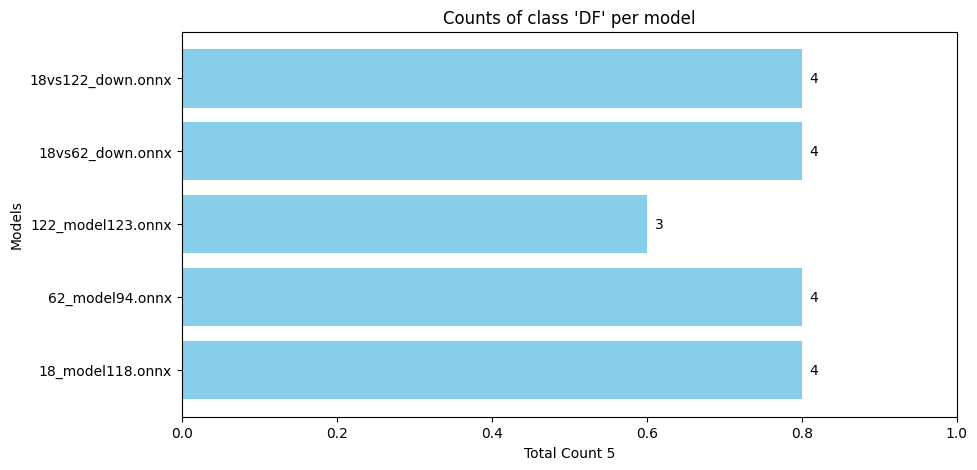

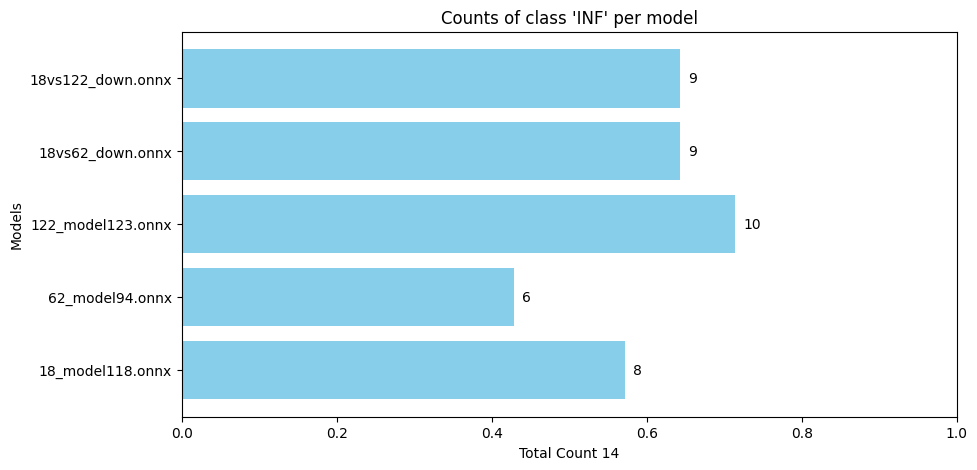

This class is not there
This class is not there


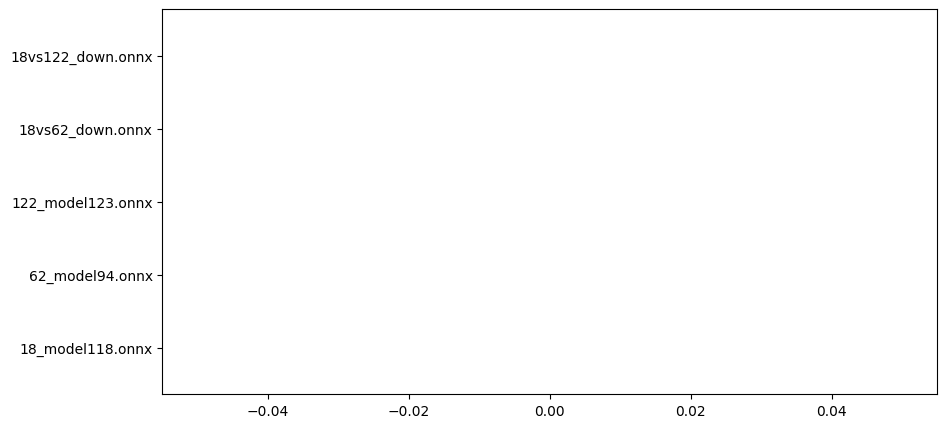

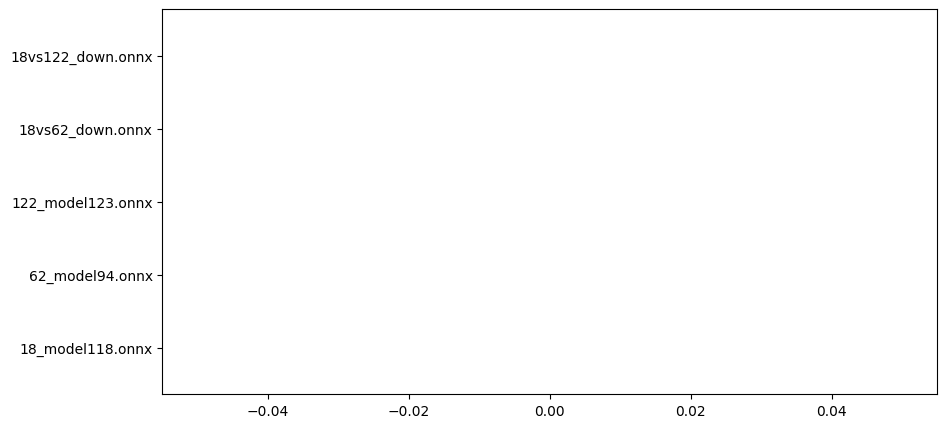

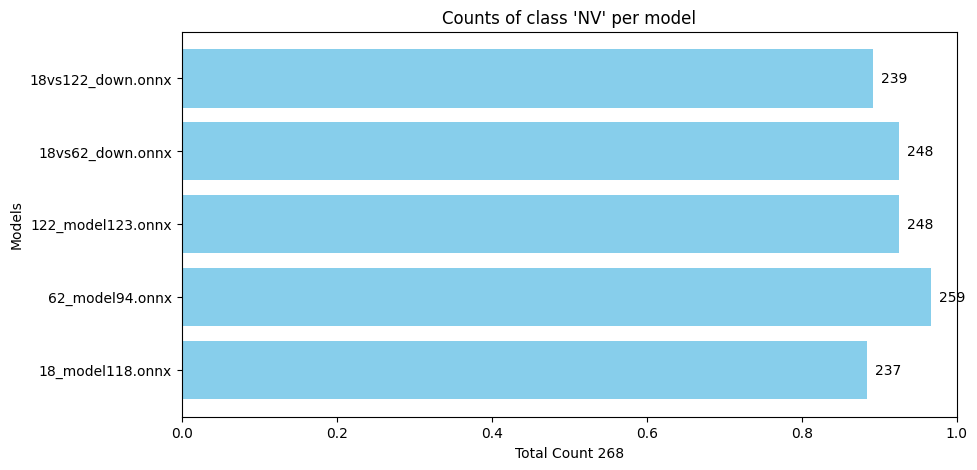

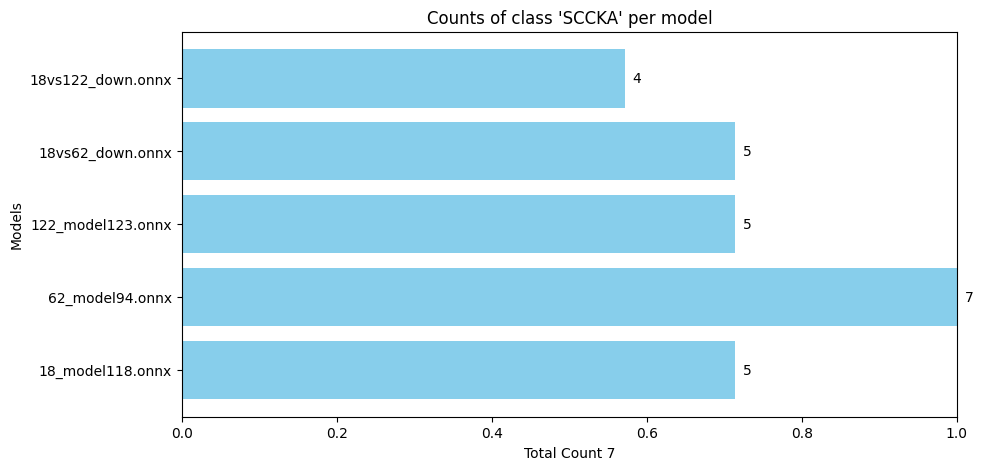

This class is not there


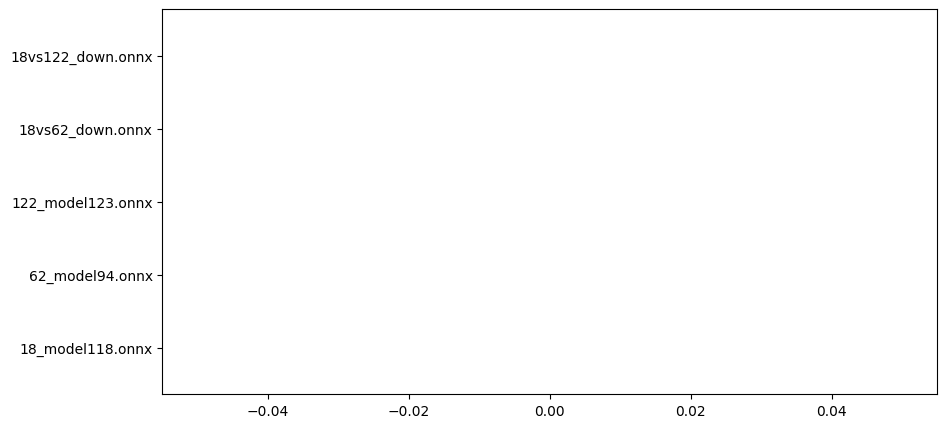

In [4]:
classes = list(next(iter(results.values())).keys())
models = list(results.keys())

counts_per_class = df["Class"].value_counts().to_dict()

for cls in classes:
    try:
        counts = [results[model][cls] for model in models]
        percents = [results[model][cls] / counts_per_class.get(cls, 1) for model in models]

        plt.figure(figsize=(10, 5))
        bars = plt.barh(
            [model.split("/")[-1] for model in models], percents, color="skyblue"
        )

        # Add count labels on each bar
        for bar in bars:
            width = bar.get_width()
            plt.text(
                width + 0.01,
                bar.get_y() + bar.get_height() / 2,
                str(int(width * counts_per_class[cls]) ),
                va="center",
                ha="left",
            )

        plt.xlabel(f"Total Count {counts_per_class[cls]}")
        plt.ylabel("Models")
        plt.xlim(0,1)
        plt.title(f"Counts of class '{cls}' per model")
        # plt.tight_layout()
        plt.show()
    except:
        print('This class is not there')